In [70]:
# Carrega as variáveis de embiente usadas pelo notebook. Estas variáveis devem ser criadas no arquivo .env, localizada no mesmo diretório do notebook
# As seguintes variáveis devem ser criadas:
# - export STR_CON=<string de conexão com o banco de dados relacional>
# - export RAW_DATA_PATH=<caminho onde os arquivos contendo o histórico de preço de cada ativo será armazenado>
# - export DATASET_PATH=<caminho onde os arquivos contendo o histórico de preço e os indicadores técnicos serão armazenados>
# - export MODELS_PATH=<caminnho onde os modelos treinados serão armazenados>
# - export TRAIN_DATASET=<caminho onde os datasets estandarizados e formatados para o treinamento serão armazenados>
%load_ext dotenv
%dotenv

# Garante que os scripts Python sejam recarregados em cada execução do notebook.
%load_ext autoreload
%autoreload 2

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Objetivo do Nobook 
<p>O objetivo deste notebook é extrair o histórico de preços de ações de banco de dados relacional, acrescentar os indicadores técnicos, rentabilidade e label de classificação e gravá-los como arquivos para que sejam usados no processo de treinamento do modelo de machine learning. O primeiro passo é obter os dados históricos de negociação de cada ativo gravá-los como arquivos individuais em disco. Estes arquivos devem conter as seguintes colunas:</p>
<ul>
<li>ticker - Código de negociação do ativo</li>
<li>dt_price - Data de negociação</li>
<li>open - Preço de abertura no dia</li>
<li>close - Preço de fechameto no dia</li>
<li>high - Preço máximo no dia</li>
<li>low - Preço mínimo no dia</li>
<li>volume - Volume financeiro negociado do ativo no dia</li>
</ul>
<p>É fundamental que os arquivos contenham exatamente estas colunas, pois a biblioteca TA-Lib (utilizada para calcularos indicadores técnicos) espera estes nomes como parâmetros de entrada para suas funções.</p>
<p><b>Exemplo</b>:</p>
<p>Lista de ativos recuperados do banco de dados: [PETR4, ITUB4, VALE3, ABEV3]</p>
<p>Arquivos gerados:</p>
<ul>
<li> PETR4.parquet </li>
<li> ITUB4.parquet </li>
<li> VALE3.parquet </li>
<li> ABEV3.parquet </li>
</ul>
<p>Uma vez gerados os arquivos <b>parquet</b> com os dados históricos de preço dos ativos, os indicadores técnicos serão calculados de acordo com as estratégias definias no arquivo de configuração <b>strategies.json</b> e a rentabilidade em X dias futuros calculada. Esta rentabilidade será usada para definir o label que será usado para classificar o ativo.</p>

### Imports

In [71]:
import os
import pandas as pd
from data_preparation import PreProcess
from db_access import StockHistory, ExportToParquet, ExportToPickle
import numpy as np

pd.options.display.max_columns = 200

### Geração dos arquivos apenas com o a série histórica de preços

In [66]:
# Obtem o historico de precos dos ativos 
str_conn = os.environ.get("STR_CON")
raw_file_path = os.environ.get("RAW_DATA_PATH")
data_file_path = os.environ.get("DATASET_PATH")
exporter = ExportToParquet()
dbo = StockHistory(str_conn)
df = dbo.select()
df["dt_price"] = df["dt_price"].astype('datetime64[ns]')
# Grava os arquivos com o histórico de preços em formato parquet em um diretório local
print(f"Gerando arquivos de preço")
for stock in df['ticker'].unique():
    df_aux = df.loc[df['ticker'] == stock]
    exporter.export(df_aux, raw_file_path, stock)
print(f"Arquivos de preço gerados com sucesso")

Gerando arquivos de preço
Arquivos de preço gerados com sucesso


### Cálculo dos indicadores técnicos, e rentabilidade dos ativos
<p>O segundo passo da preparação dos datasets consiste em incluir os indicadores técnicos ao histórico de preço de cada ativo de acordo com as estratégias de negociação definidas no arquivo de configuração, calcular a rentabilidade do ativo X dias para frente e usar esta rentabilidade para definir o label de classificação do ativo (1 se o ativo se valorizou mais do que Y% X dias após a série de dados do registro do dataset ou 0 caso contrário).</p> 
<p>Uma estratégia de negociação nada mais é do que a combinação de indicadores técnicos que serão usados como features em modelos de machine learning. A ideia é realizar diversos experimentos com diferentes estratégias para encontrar combinações que ajudem melhorar a acurácia do modelo na classificação dos ativos com maior potencial de rentabilidade no período informado.</p>
<p>Para automatizar o processo, as estratégias de negociação são configuradas em um arquivo json com a seguinte estrutura:</p>
<code>
<pre>
    "&lt;nome da estrategia&gt;":{
        "description": "&lt;Descrição da estratégia&gt;",
        "historic_period": &lt;Número inteiro que irá definir o total dias usados pelo modelo. Por exemplo, o modelo receberá um histórico de preço de 
                            60 dias para classificar o ativo&gt;,
        "profit_period": &lt;Número inteiro que definirá o período usado para calcular a rentabilidade do ativo (será usado para definir seu label).
                          Por exemplo, o modelo reberá 60 dias de cotação para classificar o ativo, se este parâmetro for setado para 10, a rentablidade 
                          usada para definir o label será calclada como: 
                          preço 10 dias após a o último dia da série de entrada/preço do último dia da série de entrada - 1&gt;,
        "shift_days": &lt;Número inteiro que define quantos dias serão "pulados" durante a geração das series temporais de preços. Por exemplo, um modelo
                       poderá ser treinado com um histórico de preços de 30 dias, a primeira série histórica será do dia 01 até o dia 30 do mês, se
                       shift_days for igual a 5 dias, a segunda série será do dia 6 (cinco dias após o início da série anterior) até o dia 6 mais 30
                       dias&gt;,
        "profit": &lt;Rentabilidade usada para definir o label de classificação de cada registro enviado para o modelo durante o treinamento. Por exemplo,
                   Se o objetivo do modelo for identificar ativos que possuam rentabiliade superior a 5% em um período de 20 dias, o valor atribuído para
                   este parâmetro deve ser 0.05&gt;,
        "functions": { -- Lista de funções que fazem parte da estratégia de negociação
            "&lt;nome "fantasia" da função&gt;":{
                "function": "&lt;nome da função na biblioteca TA-Lib, será usado para chamar a função no código&gt;",
                "params":{ -- Lista de parâmetros da função (parâmetros relacionados ao preço do ativo não devem ser listados aqui)
                    "&lt;nome da parâmetro&gt;": &lt;valor&gt;
                }                
            }
        }
    }
</pre>
</code>
<p>Exemplo de configuração:</p>
<p>Neste exemplo, a estratégia considera 90 dias de histórico de preço do ativo para classificar ativos que tenham rentabilidade superior a 5% em um período de 22 dias e para fazer isso, utiliza além do histórico de cotações os indicadores: Média móvel exponencial de 7 e 21 dias e o OBV.</p>
<code>
<pre>
{
    "EMA_7_21_OBV":{
        "description": "Combinacao de 2 medias moveis (7 e 21 dias) e OBV ",
        "historic_period": 90,
        "profit_period": 22,
        "shift_days": 5,
        "profit": 0.05,
        "functions": {
            "EMA_7":{
                "function": "EMA",
                "params":{
                    "timeperiod": 7
                }
            },
            "EMA_21": {
                "function": "EMA",
                "params":{
                    "timeperiod": 21
                }            
            },
            "OBV":{
                "function": "OBV"                  
            }
        }
    }
}
</pre>
</code>
<p>Após calcular todos os indicadores técnicos, o dataset será formatado para que as séries históricas possam ser processadas pelo primeiro modelo, que é um Autoencoder com camadas LSTM. Camadas LSTM esperam como entrada tensores com 3 dimensões (batch, timesteps, features), onde:
<pre>
batch - representa o número de registros que serão enviados ao modelo em cada iteração do treinamento (batch size)
timesteps - quantidade de dias da série temporal que serão passadas para a camada LSTM (historic_period)
features - quantidade de colunas do dataset de entrada, por exemplo se a estratégia utilizar o preço de fechamento, médias móveis de 7 e 21 dias, o dataset de entrada terá 3 features.
</pre>
<p>Além da série histórica de preços de cada ativo, o dataset de treinamento conterá o código de negociação do ativo (ticker), datas de início e fim da série temporal contida em cada registro, rentabiliade X dias a frente e o label utilizado para treinar o modelo que irá classificar os ativos. As colunas ticker, datas de início e fim da série temporal e rentabilidade não serão usadas durante o treinamento dos modelos, elas existem apenas para facilitar a validação dos dados de entrada.</p>
<pre>
Exemplo:<br/>
    * historic_period = 20
    * profit_period = 10
    * stride = 5
    * profit = 0.05
    * Valores da estratégia = close, MME7, MME21
    
Cada registro do dataset de treinamento conterá as seguintes colunas:</br>
Ticker  Data Inicio     Data Fim         Serie Histórica                     Rentabilaide    Label
XXXX4   2022-07-04      2022-07-29       18.48   18.631468   18.727143       -0.021312       0
&nbsp;                                        18.48   18.573601   18.697403
&nbsp;                                        18.50   18.490201   18.655821
&nbsp;                                        18.69   18.552069   18.579502
&nbsp;                                        .         .            .
&nbsp;                                        .         .            .
&nbsp;                                        .         .            .
&nbsp;                                        19.03   18.661552   18.616820
XXXX4   2022-07-11      2022-08-05       18.48   18.631468   18.727143       0.0621312       1
&nbsp;                                        18.48   18.573601   18.697403
&nbsp;                                        18.50   18.490201   18.655821
&nbsp;                                        18.69   18.552069   18.579502
&nbsp;                                        .         .            .
&nbsp;                                        .         .            .
&nbsp;                                        .         .            .
&nbsp;                                        19.03   18.661552   18.616820
</pre>
<p>Ao final do processo, arquivos pickle serão gravados contendo os valores calculados e formatados. Cada estratégia irá gerar um diretório contendo os arquivos com os dados e existirá um arquivo por ativo processado.</p>

In [90]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pre_process = PreProcess()
parquet_exporter = ExportToParquet()
pickle_exporter = ExportToPickle()

raw_file_path = os.environ.get("RAW_DATA_PATH")
data_file_path = os.environ.get("DATASET_PATH")
model_base_path = os.environ.get("MODELS_PATH")

columns_to_pop = ['ticker', 'dt_price', 'market', 'segment_id', 'subsector_id', 'economical_sector_id',
                  'CDLMORNINGSTAR', 'CDLSHOOTINGSTAR', 'CDLTAKURI', 'CDLHANGINGMAN', 'CDLEVENINGDOJISTAR', 
                  'CDL3OUTSIDE', 'CDLONNECK', 'CDLHAMMER', 'CDLHARAMICROSS']
columns_to_scale = ['close', 'rsi', 'macd', 'macdsignal', 'macdhist', 'rsi', 'slowk', 'slowd',
                    'diff_willr_20', 'diff_willr_80', 'dif_mfi_20', 'diff_mfi_80', 
                    'diff_rsi_70', 'diff_k_d']

path_content = os.listdir(raw_file_path)
# Filtra os arquivos parquet do diretório
path_content = [file for file in path_content if file.endswith(".parquet")]

for file in path_content:
    print(f"Processando arquivo: {raw_file_path}/{file}")
    df_raw = pd.read_parquet(os.path.join(raw_file_path, file))
    df_raw.set_index("dt_price", drop=False, inplace=True)

    # Calcula os indicadores técnicos definidos nas estratégias para cada ativo
    for strategy_name, strategy, df_tech in pre_process.calculate_strategy("strategies.json", df_raw):
        window_size = strategy["historic_period"]
        stride = strategy["stride"]
        profit_period = strategy["profit_period"]
        profit = strategy["profit"]

        df_aux = pd.DataFrame()

        # Remove os valores nulos do DataFrame
        df_tech.dropna(inplace=True)

        for col in columns_to_pop:
            df_aux[col] = df_tech.pop(col)

        df_aux.reset_index(inplace=True, drop=True)

        # Cria um MinMaxScaler para fazer o scaling das features
        scaler = MinMaxScaler().fit(df_tech[columns_to_scale])
        # Salva o scaling para ser usado após o treinamento
        pickle_exporter.export(scaler, os.path.join(model_base_path, strategy_name), file.split('.')[0])

        # Gera o dataframe com os dados redimensionados
        transformed_data = scaler.transform(df_tech[columns_to_scale])

        df_tech = pd.concat([df_aux, pd.DataFrame(transformed_data, columns=scaler.get_feature_names_out())], axis=1)

        # df_tech.set_index('dt_price', drop=False, inplace=True)

        # Formata o dataset para ser usado no modelo
        df_model = pre_process.format_dataset(df_raw, df_tech, window_size, stride, profit_period, profit, ["open", "high", "low", "market", "segment_id", "subsector_id", "economical_sector_id"])
 
        # Exporta o data set como um arquivo parquet
        parquet_exporter.export(df_model, os.path.join(data_file_path, strategy_name), file.split('.')[0])


Processando arquivo: data/raw/CPFE3.parquet
Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating WILLR_14...
Calculating MFI_14...
Calculating ROC...
Processando arquivo: data/raw/BEEF3.parquet
Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating WILLR_14...
Calculating MFI_14...
Calculating ROC...
Processando arquivo: data/raw/LOGG3.parquet
Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating WILLR_14...
Calculating MFI_14...
Calculating ROC...
Processando arquivo: data/raw/VIVT3.parquet
Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating WILLR_14...
Calculating MFI_14...
Calculating

In [92]:
df_model.head()

,ticker,dt_price_start,dt_price_ends,shape,series,profit,label
0,NTCO3,2013-02-05,2013-04-12,"(45, 25)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.020676,1
1,NTCO3,2013-02-14,2013-04-19,"(45, 25)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.004864,0
2,NTCO3,2013-02-21,2013-04-26,"(45, 25)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.035853,1
3,NTCO3,2013-02-28,2013-05-06,"(45, 25)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.052383,1
4,NTCO3,2013-03-07,2013-05-13,"(45, 25)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.076521,1


In [84]:
print(np.reshape(df_model.iloc[0]['series'],(45,30)))

[[7.00000000e+01 3.50000000e+01 9.00000000e+00 ... 6.62447386e-02
  4.07823250e-01 5.49272284e-01]
 [7.00000000e+01 3.50000000e+01 9.00000000e+00 ... 6.94191528e-02
  3.81953543e-01 4.10692984e-01]
 [7.00000000e+01 3.50000000e+01 9.00000000e+00 ... 7.13242661e-02
  3.55865138e-01 3.76417924e-01]
 ...
 [7.00000000e+01 3.50000000e+01 9.00000000e+00 ... 5.51333844e-02
  7.09283029e-01 4.95327778e-01]
 [7.00000000e+01 3.50000000e+01 9.00000000e+00 ... 5.95292048e-02
  7.16448704e-01 4.68466086e-01]
 [7.00000000e+01 3.50000000e+01 9.00000000e+00 ... 6.09844783e-02
  6.65398805e-01 3.94798691e-01]]


### Criação dos datasets usados no treinamento
<p>As últimas etapas da perparação de dados é a divisão do dataset em dois subconjuntos (treinamento e validação) e o redimensionamento dos valores, para que todos os números tenham a mesma ordem de grandeza (números entre 0 e 1). O processo de redimensionamento dos valores é feito por ativo, e os datasets resultantes são concatenados, gerando um dataset completo que será divido em 2 (treino e teste) e gravado como arquivo parquet para ser usado no treinamento do modelo.</p>

In [91]:
pre_process = PreProcess()
random_seed = 42
test_size = 0.15

pre_process.create_train_test_dataset("strategies.json", test_size, random_seed)

Processando arquivo CPFE3.parquet na estrategia indicadores_com_sinais
Processando arquivo BEEF3.parquet na estrategia indicadores_com_sinais
Processando arquivo LOGG3.parquet na estrategia indicadores_com_sinais
Processando arquivo VIVT3.parquet na estrategia indicadores_com_sinais
Processando arquivo PLPL3.parquet na estrategia indicadores_com_sinais
Processando arquivo KEPL3.parquet na estrategia indicadores_com_sinais
Processando arquivo ROMI3.parquet na estrategia indicadores_com_sinais
Processando arquivo HAPV3.parquet na estrategia indicadores_com_sinais
Processando arquivo ARZZ3.parquet na estrategia indicadores_com_sinais
Processando arquivo BBSE3.parquet na estrategia indicadores_com_sinais
Processando arquivo SOMA3.parquet na estrategia indicadores_com_sinais
Processando arquivo PETR3.parquet na estrategia indicadores_com_sinais
Processando arquivo TRPL4.parquet na estrategia indicadores_com_sinais
Processando arquivo AGRO3.parquet na estrategia indicadores_com_sinais
Proces

## Dataset baseado em sinais de negociação

In [47]:
pre_process = PreProcess()

raw_file_path = os.environ.get("RAW_DATA_PATH")
data_file_path = os.environ.get("DATASET_PATH")
model_base_path = os.environ.get("MODELS_PATH")

file = "BBDC4.parquet"
df_raw = pd.read_parquet(os.path.join(raw_file_path, file))

# Calcula os indicadores técnicos definidos nas estratégias para cada ativo
for strategy_name, strategy, df_tech in pre_process.calculate_strategy("strategies.json", df_raw):
    window_size = strategy["historic_period"]
    stride = strategy["stride"]
    profit_period = strategy["profit_period"]
    profit = strategy["profit"]


df_tech.tail()

Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating BBANDS_14...
Calculating SMA_3...
Calculating SMA_21...
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating ROC...


,ticker,dt_price,open,close,high,low,volume,upperband,middleband,lowerband,sma_3,sma_21,macd,macdsignal,macdhist,rsi,slowk,slowd,roc,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,diff_sma_3_sma_21,bband_width,diff_rsi_70,diff_k_d
31293,BBDC4,2022-08-29,19.28,19.49,19.61,19.10,19048300,20.434225,19.035714,17.637204,19.466667,19.035714,0.443176,0.469934,-0.026759,64.014946,68.198491,71.855581,0.360453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.430952,2.797021,-5.985054,-3.657091
31294,BBDC4,2022-08-30,19.66,19.43,19.68,19.39,18479100,20.322443,19.134286,17.946129,19.446667,19.134286,0.418173,0.459582,-0.041409,62.337173,57.547619,65.846594,-0.307850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312381,2.376314,-7.662827,-8.298975
31295,BBDC4,2022-08-31,19.51,18.94,19.59,18.86,50603900,20.190247,19.195238,18.200229,19.286667,19.195238,0.354730,0.438612,-0.083882,50.659810,37.445055,54.397055,-2.521873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091429,1.990018,-19.340190,-16.952000
31296,BBDC4,2022-09-01,18.95,19.10,19.37,18.65,32928000,20.074762,19.250476,18.426191,19.156667,19.250476,0.313745,0.413638,-0.099893,53.709121,28.314103,41.102259,0.844773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.093810,1.648571,-16.290879,-12.788156
31297,BBDC4,2022-09-02,19.17,19.31,19.66,19.12,49637800,19.997997,19.300000,18.602003,19.116667,19.300000,0.294811,0.389873,-0.095062,57.427975,32.164103,32.641087,1.099476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.183333,1.395994,-12.572025,-0.476984


In [90]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_preparation import PivotLevels
import talib as ta


pre_process = PreProcess()
parquet_exporter = ExportToParquet()
pickle_exporter = ExportToPickle()

raw_file_path = os.environ.get("RAW_DATA_PATH")
data_file_path = os.environ.get("DATASET_PATH")
model_base_path = os.environ.get("MODELS_PATH")
columns_to_pop = ['ticker', 'dt_price']

path_content = os.listdir(raw_file_path)
# Filtra os arquivos parquet do diretório
path_content = [file for file in path_content if file.endswith(".parquet")]

for file in path_content:
    print(f"Processando arquivo: {raw_file_path}/{file}")
    df_raw = pd.read_parquet(os.path.join(raw_file_path, file))
    df_raw.set_index("dt_price", drop=False, inplace=True)

    # Calcula os indicadores técnicos definidos nas estratégias para cada ativo
    for strategy_name, strategy, df_tech in pre_process.calculate_strategy("strategies.json", df_raw):
        window_size = strategy["historic_period"]
        stride = strategy["stride"]
        profit_period = strategy["profit_period"]
        profit = strategy["profit"]

        df_aux = pd.DataFrame()

        # Ajusta d valor do ROC
        df_tech['roc'] = df_tech['roc']/100
        # Calcula a volatilidade do ativo no periodo window_size
        df_tech['volatiliade'] = df_tech['roc'].rolling(window=window_size).std()
        # Calcula a variacao do volume
        df_tech['var_volume'] = ta.ROC(df_tech['volume'], 1)/100
        df_tech[f'vol_med_{window_size}_days'] = df_tech['volume'].rolling(window=window_size).mean()
        df_tech['diff_volume_vol_med'] = df_tech['volume']/df_tech[f'vol_med_{window_size}_days']-1
        # Calcula a distacia entre o preco de fechamento e as medias moveis
        df_tech['diff_close_sma3'] = df_tech['close'] - df_tech['sma_3']
        df_tech['diff_close_sma21'] = df_tech['close'] - df_tech['sma_21']
        df_tech['diff_sma3_sma21'] = df_tech['sma_3'] - df_tech['sma_21']
        # Calcula a largura da Bollinger Band e distancias do preco de fechamento para as bandas
        df_tech['bband_width'] = df_tech['upperband'] - df_tech['lowerband']
        df_tech['bband_close_upper'] = df_tech['upperband'] - df_tech['close']
        df_tech['bband_close_lower'] = df_tech['close'] - df_tech['lowerband']
        df_tech[f'bband_width_{window_size}_days'] = df_tech['bband_width'].rolling(window=window_size).mean()
        df_tech['diff_bband_width_avg_width'] = df_tech[f'bband_width_{window_size}_days'] - df_tech['bband_width']
        # Calcula indicadores MACD
        df_tech['diff_macd_signal'] = df_tech[f'macd'] - df_tech['macdsignal']
        # Calcula indicadores do RSI
        df_tech['rsi_is_above_70'] = (df_tech['rsi'] > 70.0).apply(int).values
        df_tech['rsi_is_under_30'] = (df_tech['rsi'] < 30.0).apply(int).values
        df_tech['diff_rsi_70'] = df_tech['rsi'] - 70.0
        df_tech['diff_rsi_30'] = df_tech['rsi'] - 30.0
        # Calcula indicadores do Stochastic Oscilator
        df_tech['stc_is_above_80'] = (df_tech['slowk'] > 80.0).apply(int).values
        df_tech['stc_is_under_20'] = (df_tech['slowk'] < 20.0).apply(int).values
        df_tech['diff_stc_k_d'] = df_tech['slowk'] - df_tech['slowd']

        # Calcula os Pivot Levels
        pivot_levels = PivotLevels(high=df_tech['high'], low=df_tech['low'], close=df_tech['close'])
        df_tech['r1'] = pivot_levels.R1
        df_tech['s1'] = pivot_levels.S1
        df_tech['r2'] = pivot_levels.R2
        df_tech['s2'] = pivot_levels.S2
        df_tech['r3'] = pivot_levels.R3
        df_tech['s3'] = pivot_levels.S3

        # Diferenca entre os Pivot Levels e o preco de fechamento
        df_tech['diff_close_r1'] = df_tech['close'] - df_tech['r1']
        df_tech['diff_close_r2'] = df_tech['close'] - df_tech['r2']
        df_tech['diff_close_r3'] = df_tech['close'] - df_tech['r3']
        df_tech['diff_close_s1'] = df_tech['close'] - df_tech['s1']
        df_tech['diff_close_s2'] = df_tech['close'] - df_tech['s2']
        df_tech['diff_close_s3'] = df_tech['close'] - df_tech['s3']

        # Caclula o coeficiente angular da regressao do preco de fechamento e adiciona ao dataframe de treinamento
        df_tech['coef_ang_close'] = pre_process.linear_regression_slope(df_tech['close'], window_size=window_size, stride=stride)
        df_tech['coef_ang_volume'] = pre_process.linear_regression_slope(df_tech['volume'], window_size=window_size, stride=stride)

        # Remove os valores nulos do DataFrame
        df_tech.dropna(inplace=True)

        df_tech['coef_ang_volat'] = pre_process.linear_regression_slope(df_tech['volatiliade'], window_size=window_size, stride=stride)
        df_tech['coef_ang_bband_width'] = pre_process.linear_regression_slope(df_tech['bband_width'], window_size=window_size, stride=stride)
        df_tech['coef_ang_macdhist'] = pre_process.linear_regression_slope(df_tech['macdhist'], window_size=window_size, stride=stride)
        df_tech['coef_ang_rsi'] = pre_process.linear_regression_slope(df_tech['rsi'], window_size=window_size, stride=stride)
        
        # Remove os valores nulos do DataFrame
        df_tech.dropna(inplace=True)

        aux = np.empty(shape=(df_tech.shape[0]))
        aux[:] = np.NaN

        i = j = 0

        while i < df_tech.shape[0]:
            profit_aux = pre_process.calculate_proftability(df_raw, df_tech['dt_price'].iloc[j], profit_period)
            aux[j] = profit_aux

            i += stride
            j += 1

        df_tech['profit'] = aux
        df_tech['label'] = (df_tech['profit'] >= profit).astype(int)

         # Exporta o data set como um arquivo pickle (arquivos parquet não suportam arrays multidimensionais)
        print(f"Exportando arquivo {os.path.join(data_file_path, strategy_name)}")
        parquet_exporter.export(df_tech, os.path.join(data_file_path, strategy_name), file.split('.')[0])


Processando arquivo: data/raw/CPFE3.parquet
Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating BBANDS_14...
Calculating SMA_3...
Calculating SMA_21...
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating ROC...
Exportando arquivo data/datasets/Sinais-de-Negociacao
Processando arquivo: data/raw/PMAM3.parquet
Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating BBANDS_14...
Calculating SMA_3...
Calculating SMA_21...
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating ROC...
Exportando arquivo data/datasets/Sinais-de-Negociacao
Processando arquivo: data/raw/BEEF3.parquet
Processing strategy: Modelo para selecionar ativos atraves de sinais de negociacao
Calculating BBANDS_14...
Calculating SMA_3...
Calculating SMA_21...
Calculating MACD...
Calculating RSI...
Calculating STOCH...
Calculating ROC...
Exportando arquivo data/datasets/Sinais-de-Negociacao
Processando arqu

In [100]:
from sklearn.model_selection import train_test_split

test_size = 0.15
random_seed = 42

files_path = os.path.join(data_file_path, "Sinais-de-Negociacao")
path_content = os.listdir(files_path)
# Filtra os arquivos parquet do diretório
path_content = [file for file in path_content if file.endswith(".parquet")]

read_first = True

for file in path_content:
    df_aux = pd.read_parquet(os.path.join(files_path, file))
    
    if not read_first:
        df = pd.concat([df, df_aux], ignore_index=True)
    else:
        df = df_aux.copy(deep=True)
        read_first = False

model_cols = ["macd", "macdhist", "rsi", "slowk", "slowd", "volatiliade", "var_volume", "diff_volume_vol_med", "diff_close_sma3", 
              "bband_close_upper", "bband_close_lower", "bband_width_30_days", "diff_bband_width_avg_width", "diff_sma3_sma21", 
              "diff_rsi_70", "diff_stc_k_d", "diff_close_r1", "diff_close_r3", "diff_close_s1","bband_width",
              "diff_close_s3", "coef_ang_close", "coef_ang_volume", "coef_ang_volat", "coef_ang_bband_width", "coef_ang_macdhist", "coef_ang_rsi",
              "CDL3BLACKCROWS", "CDL3INSIDE", "CDL3LINESTRIKE", "CDL3OUTSIDE", "CDL3WHITESOLDIERS",
              "CDLADVANCEBLOCK", "CDLBELTHOLD", "CDLCLOSINGMARUBOZU", 
              "CDLCOUNTERATTACK", "CDLDARKCLOUDCOVER", "CDLDOJI", "CDLDOJISTAR", "CDLDRAGONFLYDOJI", "CDLENGULFING", "CDLEVENINGDOJISTAR",
              "CDLEVENINGSTAR", "CDLGAPSIDESIDEWHITE", "CDLGRAVESTONEDOJI", "CDLHAMMER", "CDLHANGINGMAN", "CDLHARAMI", "CDLHARAMICROSS",
              "CDLHIGHWAVE", "CDLHIKKAKE", "CDLHIKKAKEMOD", "CDLHOMINGPIGEON", "CDLIDENTICAL3CROWS", "CDLINNECK", "CDLINVERTEDHAMMER",
              "CDLLADDERBOTTOM", "CDLLONGLEGGEDDOJI", "CDLLONGLINE", "CDLMARUBOZU", "CDLMATCHINGLOW",
              "CDLMORNINGDOJISTAR", "CDLMORNINGSTAR", "CDLONNECK", "CDLPIERCING", "CDLRICKSHAWMAN", "CDLRISEFALL3METHODS",
              "CDLSEPARATINGLINES", "CDLSHOOTINGSTAR", "CDLSHORTLINE", "CDLSPINNINGTOP", "CDLSTALLEDPATTERN", "CDLSTICKSANDWICH",
              "CDLTAKURI", "CDLTASUKIGAP", "CDLTHRUSTING", "CDLTRISTAR", "CDLUNIQUE3RIVER", "CDLXSIDEGAP3METHODS"]

if 'label' in df.columns:
    Y = df.pop('label')

# Gera as bases de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(df[model_cols].values, 
                                                    Y.values, 
                                                    test_size=test_size, 
                                                    stratify=Y.values, 
                                                    random_state=random_seed)

In [101]:
X_train.shape

(290380, 79)

In [105]:
import xgboost as xgb
import os

seed = 5643

xgtrain = xgb.DMatrix(X_train, label=Y_train)
clf = xgb.XGBClassifier(max_depth = 8,
                        verbosity = 1,
                        n_estimators=5000,
                        eval_metric=['aucpr'], 
                        early_stopping_rounds=20, 
                        objective = 'binary:logistic',
                        learning_rate=0.1, 
                        nthread=max(os.cpu_count()-4, 1),
                        subsample=1.0,
                        colsample_bytree=1.0,
                        seed=seed)

xgb_param = clf.get_xgb_params()

# print ('Start cross validation')
# cvresult = xgb.cv(xgb_param, 
#                   xgtrain, 
#                   num_boost_round=2000, 
#                   nfold=10, 
#                   metrics=['auc'],
#                   early_stopping_rounds=20, 
#                   stratified=True, 
#                   seed=seed)

# print('Best number of trees = {}'.format(cvresult.shape[0]))
# clf.set_params(n_estimators=cvresult.shape[0])
print('Fit on the training data')
eval_set = [(X_test, Y_test)]
clf.fit(X_train, Y_train, eval_set=eval_set, verbose=True)


Fit on the training data
[0]	validation_0-aucpr:0.45016
[1]	validation_0-aucpr:0.45570
[2]	validation_0-aucpr:0.46062
[3]	validation_0-aucpr:0.46368
[4]	validation_0-aucpr:0.46688
[5]	validation_0-aucpr:0.46969
[6]	validation_0-aucpr:0.47398
[7]	validation_0-aucpr:0.47744
[8]	validation_0-aucpr:0.47980
[9]	validation_0-aucpr:0.48226
[10]	validation_0-aucpr:0.48347
[11]	validation_0-aucpr:0.48570
[12]	validation_0-aucpr:0.48680
[13]	validation_0-aucpr:0.48784
[14]	validation_0-aucpr:0.48886
[15]	validation_0-aucpr:0.49092
[16]	validation_0-aucpr:0.49141
[17]	validation_0-aucpr:0.49281
[18]	validation_0-aucpr:0.49385
[19]	validation_0-aucpr:0.49414
[20]	validation_0-aucpr:0.49513
[21]	validation_0-aucpr:0.49546
[22]	validation_0-aucpr:0.49701
[23]	validation_0-aucpr:0.49784
[24]	validation_0-aucpr:0.49847
[25]	validation_0-aucpr:0.49920
[26]	validation_0-aucpr:0.49946
[27]	validation_0-aucpr:0.49957
[28]	validation_0-aucpr:0.50052
[29]	validation_0-aucpr:0.50133
[30]	validation_0-aucpr:0

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=20, enable_categorical=False,
              eval_metric=['aucpr'], feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=8, nthread=8,
              num_parallel_tree=1, predictor='auto', ...)

In [54]:
cvresult.describe()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.925081,0.001412,0.664066,0.003514
std,0.087297,0.001148,0.019852,0.000393
min,0.572117,0.000149,0.558830,0.002771
25%,0.895708,0.000487,0.656100,0.003231
50%,0.963964,0.000727,0.670538,0.003512
75%,0.986692,0.002559,0.678429,0.003606
max,0.995196,0.004291,0.683943,0.005428


In [107]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score



Y_test_predict = (clf.predict(X_test).flatten() > 0.5).astype(int)
print(f"Accuracy: {accuracy_score(Y_test, Y_test_predict):.4f}")
print("Matriz de confusao:\n", confusion_matrix(Y_test, Y_test_predict))
print(f"Precision: {precision_score(Y_test, Y_test_predict):.4f}")
print(f"Recall: {recall_score(Y_test, Y_test_predict):.4f}")
print(f"F1 Score: {f1_score(Y_test, Y_test_predict):.4f}")


Accuracy: 0.6621
Matriz de confusao:
 [[29481  2267]
 [15046  4450]]
Precision: 0.6625
Recall: 0.2283
F1 Score: 0.3395


In [106]:
features = list(zip(model_cols, clf.feature_importances_))
features.sort(key = lambda i: i[1], reverse = True)
features

[('diff_rsi_70', 0.0326047),
 ('coef_ang_volat', 0.017790116),
 ('volatiliade', 0.01762561),
 ('bband_width_30_days', 0.017027244),
 ('CDLMORNINGSTAR', 0.01669346),
 ('CDLSHOOTINGSTAR', 0.01646173),
 ('coef_ang_close', 0.016404405),
 ('coef_ang_rsi', 0.016368551),
 ('bband_width', 0.016179321),
 ('coef_ang_macdhist', 0.016111474),
 ('CDLTAKURI', 0.016015047),
 ('macd', 0.015939247),
 ('coef_ang_bband_width', 0.015422124),
 ('coef_ang_volume', 0.015258931),
 ('CDLGRAVESTONEDOJI', 0.015084462),
 ('rsi', 0.015047463),
 ('CDLHANGINGMAN', 0.015037134),
 ('diff_bband_width_avg_width', 0.014938443),
 ('CDLEVENINGDOJISTAR', 0.01455964),
 ('diff_sma3_sma21', 0.014287617),
 ('macdhist', 0.014246269),
 ('CDL3OUTSIDE', 0.014192039),
 ('CDLONNECK', 0.014122171),
 ('CDLHAMMER', 0.014022468),
 ('CDLHARAMICROSS', 0.013883036),
 ('diff_close_s3', 0.013878056),
 ('CDL3INSIDE', 0.013870875),
 ('slowd', 0.013819042),
 ('CDLINNECK', 0.013747628),
 ('CDLDRAGONFLYDOJI', 0.013691743),
 ('bband_close_lower', 0

[19592.57931034]


<AxesSubplot: >

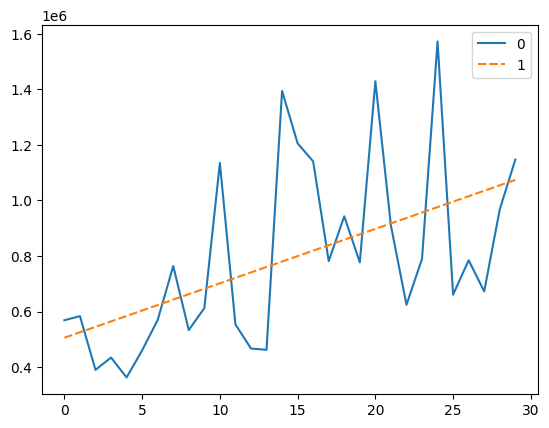

In [91]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

window_size = 30

X = np.array(range(window_size)).reshape(-1,1)
Y = df_tech['volume'][:30].values
model = LinearRegression().fit(X, Y)
pred = model.predict(np.array(range(30)).reshape(-1,1))
print(model.coef_)
sns.lineplot(data=[df_tech['volume'][:30].values, pred])

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pre_process = PreProcess()
parquet_exporter = ExportToParquet()
pickle_exporter = ExportToPickle()

raw_file_path = os.environ.get("RAW_DATA_PATH")
data_file_path = os.environ.get("DATASET_PATH")
model_base_path = os.environ.get("MODELS_PATH")
columns_to_pop = ['ticker', 'dt_price']

path_content = os.listdir(raw_file_path)
# Filtra os arquivos parquet do diretório
# path_content = [file for file in path_content if file.endswith(".parquet")]
path_content = ["BBDC4.parquet"]

for file in path_content:
    print(f"Processando arquivo: {raw_file_path}/{file}")
    df_raw = pd.read_parquet(os.path.join(raw_file_path, file))
    df_raw.set_index("dt_price", drop=False, inplace=True)

df_raw.head()


Processando arquivo: data/raw/BBDC4.parquet


,ticker,dt_price,open,close,high,low,volume
dt_price,,,,,,,
2012-09-03,BBDC4,2012-09-03,10.32,10.53,10.54,10.32,6474712
2012-09-04,BBDC4,2012-09-04,10.44,10.41,10.51,10.31,8582972
2012-09-05,BBDC4,2012-09-05,10.49,10.44,10.51,10.28,6948078
2012-09-06,BBDC4,2012-09-06,10.50,10.55,10.68,10.39,8533306
2012-09-10,BBDC4,2012-09-10,10.71,10.56,10.74,10.54,7512397


In [18]:
# Calcula os indicadores técnicos definidos nas estratégias para cada ativo
for strategy_name, strategy, df_tech in pre_process.calculate_strategy("strategies.json", df_raw):
    window_size = strategy["historic_period"]
    stride = strategy["stride"]
    profit_period = strategy["profit_period"]
    profit = strategy["profit"]

df_tech.tail()

Processing strategy: Todos os indicadores
Calculating BBANDS_14...
Calculating DEMA_7...
Calculating DEMA_21...
Calculating EMA_7...
Calculating EMA_21...
Calculating HT_TRENDLINE...
Calculating KAMA_7...
Calculating KAMA_21...
Calculating MAMA...
Calculating SAR...
Calculating SMA_7...
Calculating SMA_21...
Calculating T3_7...
Calculating T3_21...
Calculating TRIMA_7...
Calculating TRIMA_21...
Calculating WMA_7...
Calculating WMA_21...
Calculating ADX...
Calculating ADXR...
Calculating APO...
Calculating MOM...
Calculating PLUS_DI...
Calculating PLUS_DM...
Calculating PPO...
Calculating AROON...
Calculating BOP...
Calculating CCI...
Calculating CMO...
Calculating DX...
Calculating MACD...
Calculating MFI...
Calculating MINUS_DI...
Calculating MINUS_DM...
Calculating ROC...
Calculating ROCP...
Calculating ROCR...
Calculating RSI...
Calculating STOCH...
Calculating TRIX...
Calculating ULTOSC...
Calculating WILLR...
Calculating AD...
Calculating OBV...
Calculating ADOSC...
Calculating AT

,ticker,dt_price,open,close,high,low,volume,upperband,middleband,lowerband,dema_7,dema_21,ema_7,ema_21,ht_trendline,kama_7,kama_21,mama,fama,sar,sma_7,sma_21,T3_7,T3_21,trima_7,trima_21,wma_7,wma_21,adx,adxr,apo,mom,plus_di,plus_dm,ppo,aroondown,aroonup,bop,cci,cmo,dx,macd,macdsignal,macdhist,mfi,minus_di,minus_dm,roc,rocp,rocr,rsi,slowk,slowd,trix,ultosc,willr,ad,obv,adosc,atr,natr,trange
dt_price,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-08-29,BBDC4,2022-08-29,19.28,19.49,19.61,19.10,19048300,20.434225,19.035714,17.637204,19.516080,19.645830,19.448229,19.026913,18.127861,19.592741,19.389103,19.474580,19.042251,19.835627,19.445714,19.035714,19.367103,18.074481,19.425625,19.236116,19.443214,19.352424,20.598516,21.093336,0.827244,2.09,42.927683,2.117138,4.424491,4.761905,66.666667,0.411765,43.646505,22.623263,14.440454,0.443176,0.469934,-0.026759,81.856492,17.334145,1.475262,12.011494,0.120115,1.120115,61.311631,57.173140,60.665090,0.204942,49.144495,-15.471698,2.029733e+08,9.863429e+08,-7.734523e+05,0.405273,2.079389,0.51
2022-08-30,BBDC4,2022-08-30,19.66,19.43,19.68,19.39,18479100,20.322443,19.134286,17.946129,19.491142,19.659522,19.443672,19.063558,18.190694,19.587668,19.395432,19.472351,19.053004,19.806202,19.422857,19.134286,19.392126,18.135296,19.432500,19.322231,19.439286,19.388268,20.390300,20.570893,0.736731,2.07,42.691085,2.086322,3.922793,0.000000,61.904762,-0.793103,50.979192,20.668933,16.225979,0.418173,0.459582,-0.041409,85.257800,16.735381,1.405012,11.923963,0.119240,1.119240,60.334467,52.880991,56.453372,0.215964,45.237493,-18.431373,1.895919e+08,1.004822e+09,-5.451449e+06,0.399784,2.057559,0.29
2022-08-31,BBDC4,2022-08-31,19.51,18.94,19.59,18.86,50603900,20.190247,19.195238,18.200229,19.258918,19.583899,19.317754,19.052325,18.235773,19.538194,19.365076,19.445734,19.062822,19.777954,19.368571,19.195238,19.398217,18.195885,19.411250,19.382893,19.318571,19.370606,19.434230,19.765775,0.627949,1.28,41.272277,1.986973,3.331225,0.000000,57.142857,-0.780822,-6.932668,6.160457,0.312816,0.354730,0.438612,-0.083882,77.300797,21.409309,1.868107,7.248018,0.072480,1.072480,53.080229,47.838143,52.630758,0.222639,40.366698,-40.851064,1.500792e+08,9.542181e+08,-1.944179e+07,0.415508,2.193814,0.73
2022-09-01,BBDC4,2022-09-01,18.95,19.10,19.37,18.65,32928000,20.074762,19.250476,18.426191,19.178360,19.543848,19.263316,19.056659,18.282530,19.508210,19.349104,19.428447,19.071963,19.722877,19.317143,19.250476,19.389038,18.255550,19.363750,19.421405,19.251429,19.361948,18.789009,19.362133,0.506859,1.16,37.733514,1.892355,2.678632,0.000000,52.380952,0.208333,-36.626140,9.875653,5.884598,0.313745,0.413638,-0.099893,72.233256,22.027824,1.989149,6.465998,0.064660,1.064660,54.937826,44.101871,48.273668,0.226394,42.339681,-37.558685,1.583112e+08,9.212901e+08,-2.077840e+07,0.430008,2.251350,0.72
2022-09-02,BBDC4,2022-09-02,19.17,19.31,19.66,19.12,49637800,19.997997,19.300000,18.602003,19.220023,19.543527,19.274987,19.079690,18.360865,19.506792,19.347000,19.369223,19.146278,18.650000,19.311429,19.300000,19.374135,18.314005,19.303125,19.439835,19.249643,19.367359,17.992076,18.697778,0.397692,1.04,39.208191,2.092243,2.093414,4.761905,47.619048,0.259259,18.423991,14.538538,2.053419,0.294811,0.389873,-0.095062,72.513487,20.681168,1.894428,5.692392,0.056924,1.056924,57.269269,42.857274,44.932429,0.228569,42.987260,-27.699531,1.436038e+08,9.709279e+08,-2.411591e+07,0.436198,2.258923,0.56
